In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-05-29 19:16:17--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-05-29 19:16:18 (20.4 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


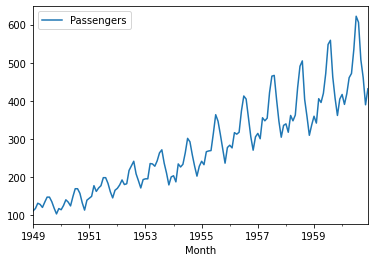

In [ ]:
df.plot();

In [ ]:
df['1stdiff'] = df['Passengers'].diff()

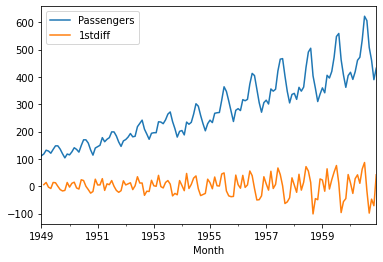

In [ ]:
df.plot();

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

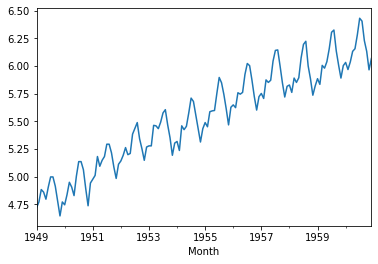

In [ ]:
df['LogPassengers'].plot();

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [ ]:
arima_result = arima.fit()

In [ ]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

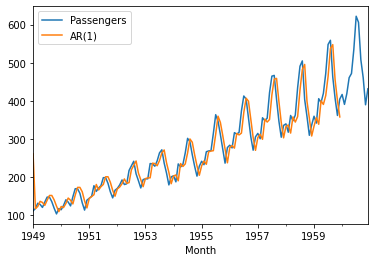

In [ ]:
df[['Passengers', 'AR(1)']].plot();

In [ ]:
forecast, stderr, confint = arima_result.forecast(Ntest)
df.loc[test_idx, 'AR(1)'] = forecast

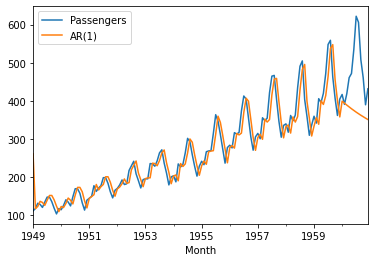

In [ ]:
df[['Passengers', 'AR(1)']].plot();

In [ ]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(df['Passengers'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  forecast, stderr, confint = result.forecast(Ntest)
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend()

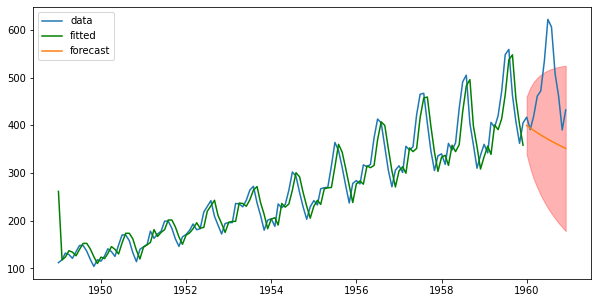

In [ ]:
plot_fit_and_forecast(arima_result)

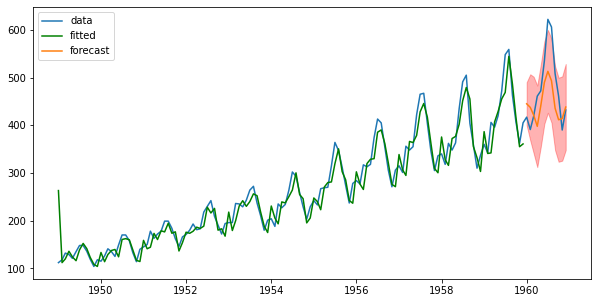

In [ ]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

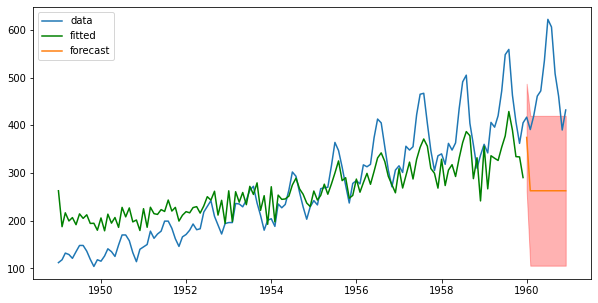

In [ ]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [ ]:
df['Log1stDiff'] = df['LogPassengers'].diff()

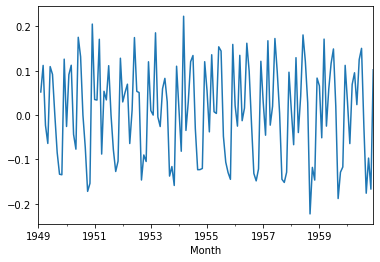

In [ ]:
df['Log1stDiff'].plot();

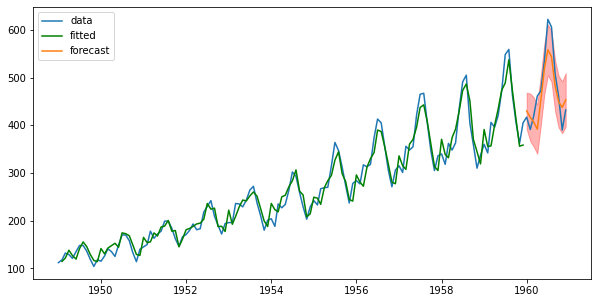

In [ ]:
arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1], \
                              typ='levels')

  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  # forecast the test set
  forecast, stderr, confint = result.forecast(Ntest)
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

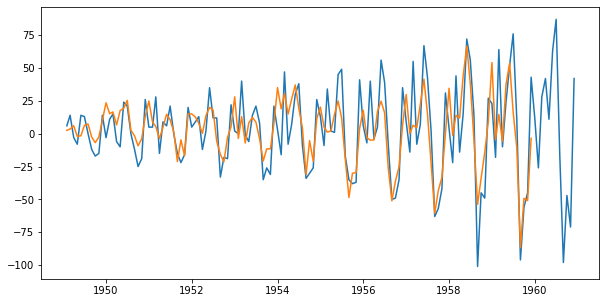

In [ ]:
def plot_difference(result, d, col='Passengers'):
  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  # train_pred = result.fittedvalues
  diff = df[col].diff()
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(diff, label='true 1st difference')
  ax.plot(train_pred, label='fitted 1st difference');

plot_difference(arima_result_811, 1)

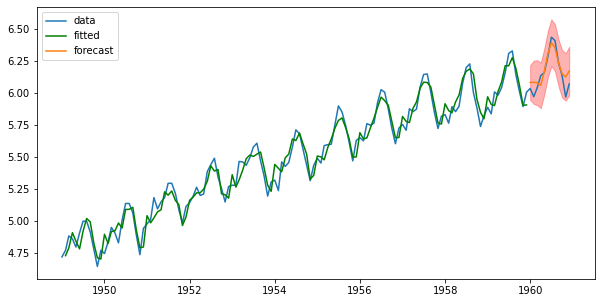

In [ ]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

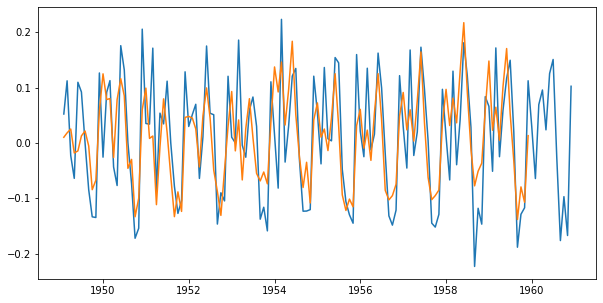

In [ ]:
plot_difference(arima_result_log811, 1, col='LogPassengers')

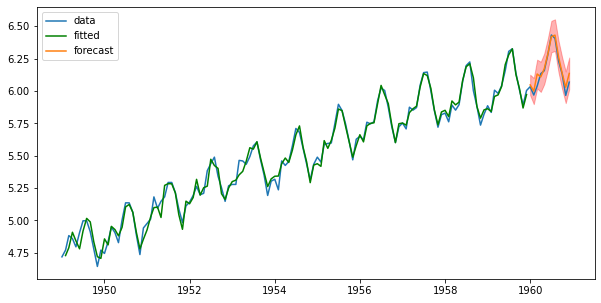

In [ ]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [ ]:
def rmse(result, is_logged):
  forecast, stderr, confint = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t - y)**2))

In [ ]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 38.5506941883442
ARIMA(8,1,1) logged: 32.22406753479829
ARIMA(12,1,0) logged: 18.611920008143862
